# MNIST DATASET IMAGE RECOGNITION

A tutorial "How to start" on MNIST dataset. More on a few of many attempts can be found here: http://yann.lecun.com/exdb/mnist/

First we need to import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Then load the data:

In [2]:
train = pd.read_csv(r"C:\Users\Aron\Desktop\train.csv")
test = pd.read_csv(r"C:\Users\Aron\Desktop\test.csv")

And look it up. Every image is described by the label column (0 to 9) and 784 pixels (0 or 255).

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

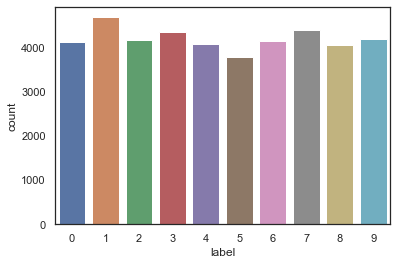

In [4]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

Preparing the data we can see how numbers are distributed throughout the whole dataset. Now we can also check is there any null values in teh datasets:

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Then we need to normalize the train and test data to reduce illumination's difference and make our CNN works faster:

In [7]:
X_train = X_train / 255.0
test = test / 255.0

Also we need to reshape the data to a 3D matrices (28x28x1), because Keras needs an extra dimension and grayscale images use only 1 channel:

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Next step is perfrom one hot encoding on the labels so i.e. 3 is encoded to vector [0,0,0,1,0,0,0,0,0,0,0]:

In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)

# Training the model

First thing is splitting the train and the validation set for the fitting.

In [10]:
random_seed = 2

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

Here is the most important part - building a net. Now, depending of the architecture of the net and the parameters set, the final accuracy might change drastically. Combination of convolution and pooling layers is giving the best results coming to the set, as it combines learning of local & global features of the image. Relu activation function adds nonlinearity. Pooling layers act as downsampling filters -  It looks at the 2 neighboring pixels and picks the maximal value, which reduces the computational cost. Dropout is when randomly selected neurons are ignored during training, improving generalization. Flattening technique is used to convert the final feature maps into a one single 1D vector, from which then fully connected layers make a use.

In [12]:
#CNN architechture in that case is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Then very important function is the optimizer. It will improve the parameters in order to minimise the loss. There are plenty of them, including famous Adam optimizer but this time we will use RMSprop.
As a loss function we use a specific form for categorical classifications called the "categorical_crossentropy".
The metric function "accuracy" is used to evaluate the performance of our model.

In [13]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [14]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Now it is time of the annealing method of the learning rate, which helps the optimizer converge faster and closest to the global minimum. Using the ReduceLROnPlateau function we want to reduce the learning rate, while on training, by half if the accuracy is not improved after 3 epochs.

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

We must also set our epochs number and batch size. After some playing with the epochs number we can set it to 30.

In [16]:
epochs = 30
batch_size = 86

Last important method before fitting our model is a data augmentation technique, which is generating more training data by randomly changing the images' scale, rotation, flips and so on. It will force the net to learn only the features that are translation-invariant, helping to avoid overfitting problem. 

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

Now it is time to fit the model with all the data:

In [18]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size), epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0]//batch_size, callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
439/439 - 102s - loss: 0.3938 - accuracy: 0.8722 - val_loss: 0.0525 - val_accuracy: 0.9821
Epoch 2/30
439/439 - 103s - loss: 0.1264 - accuracy: 0.9622 - val_loss: 0.0439 - val_accuracy: 0.9862
Epoch 3/30
439/439 - 103s - loss: 0.0921 - accuracy: 0.9725 - val_loss: 0.0351 - val_accuracy: 0.9905
Epoch 4/30
439/439 - 104s - loss: 0.0837 - accuracy: 0.9751 - val_loss: 0.0498 - val_accuracy: 0.9836
Epoch 5/30
439/439 - 108s - loss: 0.0727 - accuracy: 0.9793 - val_loss: 0.0310 - val_accuracy: 0.9914
Epoch 6/30
439/439 - 110s - loss: 0.0699 - accuracy: 0.9794 - val_loss: 0.0277 - val_accuracy: 0.9919
Epoch 7/30
439/439 - 108s - loss: 0.0647 - accuracy: 0.9813 - val_loss: 0.0302 - val_accuracy: 0.9917
Epoch 8/30
439/439 - 109s - loss: 0.0614 - accuracy: 0.9826 - val_loss: 0.0272 - val_accuracy: 0.9929
Epoch 9/30
439/439 - 107s - loss: 0.0592 - accuracy: 0.9831 - val_loss: 0.0381 - val_accuracy: 0.9905
Epoch 

Now to present final outcome:

In [19]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0186, final accuracy: 0.9950


We can also plot the loss and accuracy curves for training and validation: 

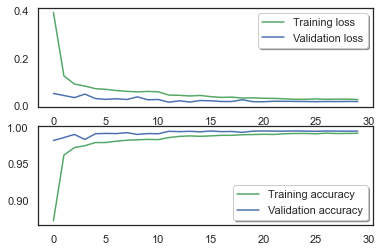

In [20]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='g', label="Training loss")
ax[0].plot(history.history['val_loss'], color='b', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='g', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Printing confusion matrix will show us what were the most misleading pairs:

In [21]:
y_hat = model.predict(X_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[410   0   0   1   0   0   0   0   0   0]
 [  0 483   0   0   0   0   0   1   1   0]
 [  0   0 402   0   0   0   0   0   1   0]
 [  0   0   0 416   0   0   0   0   2   0]
 [  0   0   0   0 456   0   1   0   0   4]
 [  0   0   0   0   0 369   1   0   2   0]
 [  0   0   0   0   0   0 412   0   1   0]
 [  0   0   0   0   0   0   0 446   0   0]
 [  0   0   0   0   1   0   0   0 380   1]
 [  1   0   0   0   2   0   0   1   0 405]]


It looks like the biggest problems are to differentiate 4 and 9, which is kind of fair, when we look at these numbers. Below we can predict our results and submit file to csv.

In [22]:
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [23]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_final.csv",index=False)